In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch.nn.functional as F
from datetime import datetime
from vqvae import Encoder, Decoder, VectorQuantizer
import lpips

## PatchGAN Disriminator

In [2]:
class MNISTPatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
                nn.LeakyReLU(0.2)
            ),
            self.__make_block(in_channels=4, out_channels=16, kernel_size=4, stride=2, padding=1),
            self.__make_block(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            self.__make_block(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            self.__make_block(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0), # B x 1 x 3 x 3
        )
    
    def __make_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.net(x)

MNISTPatchDiscriminator()(torch.randn(16, 1, 32, 32)).shape

torch.Size([16, 1, 4, 4])

## LPIPS

`!pip install lpips`

In [3]:
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\Arman\Desktop\CMSC740_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Arman\Desktop\CMSC740_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Arman\Desktop\CMSC740_Project\.venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


In [4]:
imgs0 = torch.zeros(2, 3, 64, 64)
imgs1 = torch.zeros(2, 3, 64, 64)
d = loss_fn_vgg(imgs0, imgs1)
d, d.shape

(tensor([[[[0.]]],
 
 
         [[[0.]]]], grad_fn=<AddBackward0>),
 torch.Size([2, 1, 1, 1]))

## Train on MNIST

In [5]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(0.), tensor(0.9922))

In [6]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
LAMBDA_COMMITMENT = 0.25
NUM_EMBEDDINGS = 50
DIM_EMBEDDINGS = 64
RECON_LOSS_LAMBDA = 1
PERCEPT_LOSS_LAMBDA = 1
DISC_LOSS_LAMBDA = 1

In [2]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

encoder = Encoder(img_channels=1, dim_hidden=DIM_EMBEDDINGS).to(device)
decoder = Decoder(dim_hidden=DIM_EMBEDDINGS, img_channels=1).to(device)
vq = VectorQuantizer(num_embeddings=NUM_EMBEDDINGS, dim_embeddings=DIM_EMBEDDINGS).to(device)

disc = MNISTPatchDiscriminator().to(device)

opt_vq = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(vq.parameters()), lr=1e-3)
opt_disc = torch.optim.Adam(disc.parameters(), lr=1e-3)

perceptual_loss = lpips.LPIPS(net='vgg').cuda()
reconstruction_loss = nn.MSELoss()

Reconstruction: 0.0035239392891526222 - Perceptual: 0.019706912338733673 - loss2: 0.017838500440120697 - Commitment: 0.004459625110030174 - Disc: -12.641220092773438


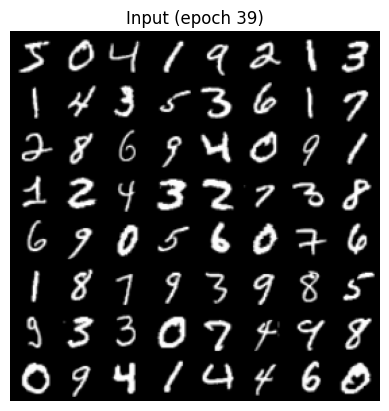

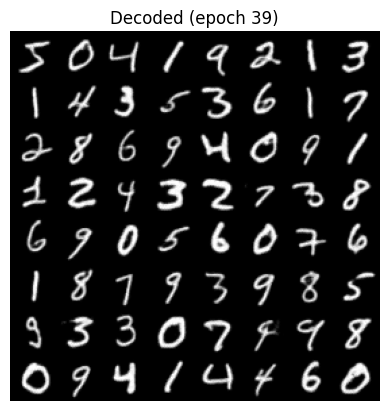

In [10]:
for epoch in range(40):
    epoch_loss = 0.

    for images, _ in train_loader:
        images = images.to(device)

        encoded = encoder(images)
        quantized = vq(encoded)
        decoded = decoder(encoded + (quantized - encoded).detach())

        disc_real = disc(images)
        disc_fake = disc(decoded)

        loss2 = torch.norm(encoded.detach() - quantized)**2
        commitment_loss = LAMBDA_COMMITMENT * torch.norm(encoded - quantized.detach())**2
        percept_loss = perceptual_loss(decoded, images).mean()
        recon_loss = reconstruction_loss(decoded, images)
        disc_loss = -torch.mean(disc_fake)
        loss = recon_loss * RECON_LOSS_LAMBDA + percept_loss * PERCEPT_LOSS_LAMBDA + loss2 + commitment_loss + disc_loss * DISC_LOSS_LAMBDA

        disc_loss = -torch.mean(disc_real) + torch.mean(disc_fake)
        
        opt_vq.zero_grad()
        loss.backward(retain_graph=True)

        opt_disc.zero_grad()
        disc_loss.backward()

        opt_vq.step()
        opt_disc.step()
    
    clear_output()
    print("Reconstruction:", recon_loss.item(), "- Perceptual:", percept_loss.item(), "- loss2:", loss2.item(), "- Commitment:", commitment_loss.item(), "- Disc:", disc_loss.item())
    show_images(torch.stack([dataset[i][0] for i in range(64)]), title=f'Input (epoch {epoch})');
    
    encoded = encoder(torch.stack([dataset[i][0] for i in range(64)]).to(device))
    decoded = decoder(vq(encoded))

    show_images(decoded.cpu().clip(0, 1), title=f'Decoded (epoch {epoch})');

You can see that the decoded images are more sharper compared to the ones we had for VQ-VAE

In [11]:
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')
torch.save(vq.state_dict(), 'vq.pth')
torch.save(disc.state_dict(), 'disc.pth')